# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
#! pip install jsonlines

In [ ]:
#! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

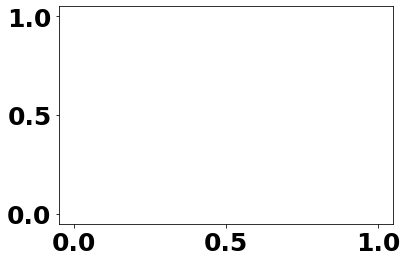

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
# CUDA1?
#data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

In [13]:
def print_category_tree_with_num_reviews_root(map_categories, inv_cat_bids, map_cat_name2id, df_reviews):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        # businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
        
        df_reviews_filtered = filter_by_businesses(df_reviews, businesses)
        num_reviews = df_reviews_filtered.rid.count()

        print(f""" {num_reviews:>8d} reviews""")

##### Make category comparisons

In [14]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [15]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [16]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [17]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [18]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [19]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [20]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [21]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [22]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [23]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [24]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [25]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=num_pairs_per_class)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [26]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:40, 163259.53it/s]


In [28]:
#businesses = get_businesses_in_category_branch(inv_cat_bids, "Mass Media", map_categories, map_cat_name2id)
#filter_by_businesses(df, businesses).rid.count()

#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [29]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:01, 103904.10it/s]
100%|██████████| 192127/192127 [00:00<00:00, 476339.10it/s]


#### Load category tree

- hierarchy of categories

In [30]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [31]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

In [35]:
# number of businesses
print(f"Number of businesses total: {len(inv_bid_cats.keys())}")
# number of reviews (total)
print(f"Number of reviews total: {df.rid.count()}")

Number of businesses total: 192127
Number of reviews total: 6685900


In [36]:
# Number of words:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df = filter_min_review_freq(df, min_ratings=5)
df = df.progress_apply(tokenize_text, axis=1)
df = df.progress_apply(count_words, axis=1)
print(f"""all*: {df["num_words"].mean()}""")

100%|██████████| 5756784/5756784 [1:00:34<00:00, 1583.89it/s]


all*: 128.92530881825687


In [ ]:
df["num_words"].describe()

```python
count    5.756784e+06
mean     1.289253e+02
std      1.218024e+02
min      1.000000e+00
25%      5.000000e+01
50%      9.100000e+01
75%      1.640000e+02
max      1.870000e+03
Name: num_words, dtype: float64
```

In [43]:
fn_df_words = data_yelp_path / "df_reviews_words.p"

with open(fn_df_words, "wb") as fp:
    pickle.dump(df, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

### Filter business without any overlap

In [37]:
# build lookup of category -> business_ids
lookup_rootcat_bid = dict()

# --> print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)
root_categories = get_root_category_items(map_categories)

for item in sorted(root_categories, key=lambda x: x["title"]):
    businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
    businesses = set(businesses)
    lookup_rootcat_bid[(item["title"], item["alias"])] = businesses

In [38]:
# remove duplicates / overlapping businesses
lookup_rootcat_bid_no_overlap = dict()

for (title, alias), businesses in lookup_rootcat_bid.items():
    # collect business ids from other categories
    businesses_other = set()
    for (title2, alias2), businesses2 in lookup_rootcat_bid.items():
        if alias2 == alias:
            continue
        businesses_other |= businesses2

    # remove other businesses
    businesses_no_overlap = businesses - businesses_other

    lookup_rootcat_bid_no_overlap[(title, alias)] = businesses_no_overlap

In [46]:
print("category | businesses | businesses_no_overlap_to_any_other")
for ((title, alias), businesses), business_no_overlap in zip(lookup_rootcat_bid.items(), lookup_rootcat_bid_no_overlap.values()):
    print(f"{title}[{alias}] | {len(businesses)}  {len(business_no_overlap)}")

category | businesses | businesses_no_overlap_to_any_other
Active Life[active] | 9521  4533
Arts & Entertainment[arts] | 6304  1225
Automotive[auto] | 13203  9755
Beauty & Spas[beautysvc] | 19370  12931
Bicycles[bicycles] | 9  0
Education[education] | 3314  831
Event Planning & Services[eventservices] | 10371  1456
Financial Services[financialservices] | 3082  1749
Food[food] | 29989  10418
Health & Medical[health] | 17171  10767
Home Services[homeservices] | 19744  11131
Hotels & Travel[hotelstravel] | 6033  1725
Local Flavor[localflavor] | 1444  120
Local Services[localservices] | 13932  4244
Mass Media[massmedia] | 319  142
Nightlife[nightlife] | 13095  2342
Pets[pets] | 4111  3470
Professional Services[professional] | 6276  1514
Public Services & Government[publicservicesgovt] | 1343  628
Religious Organizations[religiousorgs] | 547  386
Restaurants[restaurants] | 59371  35639
Shopping[shopping] | 31878  14871


In [48]:
print(f"Number businesses all (overlapping): {sum(len(bs) for bs in lookup_rootcat_bid.values())}")
print(f"Number businesses all (no overlap): {sum(len(bs) for bs in lookup_rootcat_bid_no_overlap.values())}")

Number businesses all (overlapping): 270427
Number businesses all (no overlap): 129877


### Filter from pair df

In [ ]:
# load data with more pairs
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

In [ ]:
def add_business_id(row):
    bid = row["argument1_id"].split("|")[0]
    row["business_id"] = bid
    return row

traindev_df = traindev_df.progress_apply(add_business_id, axis=1)

In [ ]:
# filter no overlapping business
all_business_ids_no_overlap = set()
for businesses in lookup_rootcat_bid_no_overlap.values():
    all_business_ids_no_overlap |= businesses

traindev_df = traindev_df[traindev_df.business_id.isin(all_business_ids_no_overlap)]

In [ ]:
# manual root category group splitting
cats = list(lookup_rootcat_bid_no_overlap.keys())

# make it repeatable
from utils_data import init_random
init_random()

cats = np.random.shuffle(cats)
groups = cats[0:6], cats[6:12], cats[12:17], cats[17:23]
groups = [tuple(g) for g in groups]

# filter business ids of group
map_cg_bids = dict()
for cg_ids in groups:
    cg_businesses = set()
    for ta_id, businesses in lookup_rootcat_bid_no_overlap.items():
        if ta_id in cg_ids:
            cg_businesses |= businesses
    
    map_cg_bids[cg_ids] = cg_businesses

In [ ]:
# build dataframes for each group
map_cg_traindev_df = dict()

for cg_ids in groups:
    businesses = map_cg_bids[cg_ids]
    cg_df = traindev_df[traindev_df.business_id.isin(businesses)]
    map_cg_traindev_df[cg_ids] = cg_df

In [ ]:
# make cross eval split traindev dfs
map_cg_train_dev_groups = dict()

for cg_ids, cg_df in map_cg_traindev_df.items():
    train_df = cg_df
    dev_dfs = [
        cg_df_o
        for cg_ids_o, cg_df_o in map_cg_traindev_df.items()
        if cg_ids_o != cg_ids
    ]
    dev_df = pd.concat(dev_dfs)
    map_cg_train_dev_groups[cg_ids] = (train_df, dev_df, dev_dfs)

## Train groups  --  Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
#! pip install --upgrade mxnet-cu102
#! pip install --upgrade gluonnlp 

In [ ]:
#! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [29]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X_arteval, names_columns_y

In [30]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [ ]:
run_name = "yelp_9_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_run_path.mkdir()

In [33]:
num_epochs = 3
batch_size = 32

In [ ]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

In [ ]:
for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Train model on group fold {cg_ids} #{len(train_df)}...")
    
    with Timer("prepare training / validation data"):
        X_train, y_train = train_df[names_columns_X_arteval], train_df[names_columns_y]
        X_dev, y_dev = dev_df[names_columns_X_arteval], dev_df[names_columns_y]

        _, data_train = transform_dataset(X_train, y_train, transform)
        _, data_dev = transform_dataset(X_dev, y_dev, transform)

    run_name = f"yelp_9_pro128BCE_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    fn_run_path.mkdir()

    fn_group = fn_run_path / "group_data.p"
    with open(fn_group, "wb") as fp:
        pickle.dump(cg_ids, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with Timer(f"train model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=num_epochs, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)
        
    with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        with open(fn_run_path / f"{run_name}_g{i}_preds.p", "wb") as fp:
            pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {pairtype}", heatmap=False)
        plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on pairtype {pairtype}", values_format="d", cmap="Blues", include_colorbar=False)
        plt.show()

---

---
---
---

---

In [36]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_1_pro128BCE

mkdir: cannot create directory ‘data/yelp_1_pro128BCE’: File exists


In [ ]:
run_name = "yelp_3_arts_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "Arts & Entertainment"

! mkdir data/yelp_3_arts_pro128BCE

---

##### Training with TRAIN set

In [ ]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

In [ ]:
plot_train_stats(stats)

##### Results with validation set (DEV set)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [ ]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 3 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

### Load other categories and evaluate

In [34]:
fn_model_state = fn_run_path / f"bert.model.checkpoint{num_epochs - 1}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_1_pro128BCE/bert.model.checkpoint2.params ...


In [35]:
# lst_root_categories
root_categories = get_root_category_items(map_categories)
root_categories = sorted(root_categories, key=lambda x: x["title"])
root_category_labels = [x["title"] for x in root_categories]

In [ ]:
results_cross_no_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # without overlap
    df_other = filter_root_category_businesses_not_other(root_category_label, category_name, inv_cat_bids, map_categories, map_cat_name2id)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_no_overlap[root_category_label] = res_one

Work on Active Life ...


  2%|▏         | 36/2039 [00:00<00:05, 357.95it/s]

#ss (pos) 4078
#ss (neg) 4078


100%|██████████| 2039/2039 [00:03<00:00, 533.42it/s]


#nss 8156
#~ss 16312
review pairs: 16312


  0%|          | 0/510 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 510/510 [02:16<00:00,  4.21it/s]


Time for [prediction]: 0:02:16.491062
Confusion Matrix:
[[6564 1592]
 [1635 6521]]

CM: [6564 1592 1635 6521] 
[tn, fp, fn, tp]
  accuracy: 0.802
 precision: 0.802
    recall: 0.802
  f1-score: 0.802

Accuracy:  0.802 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Active Life]:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      8156
           1       0.80      0.80      0.80      8156

    accuracy                           0.80     16312
   macro avg       0.80      0.80      0.80     16312
weighted avg       0.80      0.80      0.80     16312



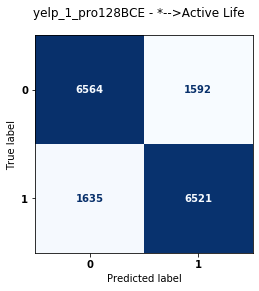

Work on Arts & Entertainment ...


  0%|          | 0/2279 [00:00<?, ?it/s]

#ss (pos) 4558
#ss (neg) 4558


100%|██████████| 2279/2279 [00:04<00:00, 508.19it/s]


#nss 9116
#~ss 18232
review pairs: 18232


  0%|          | 0/570 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 570/570 [02:29<00:00,  4.06it/s]


Time for [prediction]: 0:02:29.885589
Confusion Matrix:
[[7011 2105]
 [2168 6948]]

CM: [7011 2105 2168 6948] 
[tn, fp, fn, tp]
  accuracy: 0.766
 precision: 0.766
    recall: 0.766
  f1-score: 0.766

Accuracy:  0.766 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      9116
           1       0.77      0.76      0.76      9116

    accuracy                           0.77     18232
   macro avg       0.77      0.77      0.77     18232
weighted avg       0.77      0.77      0.77     18232



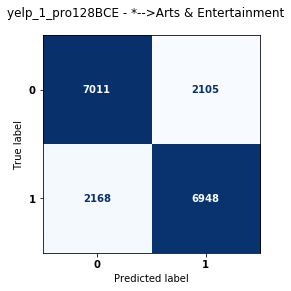

Work on Automotive ...


100%|██████████| 2848/2848 [00:05<00:00, 506.60it/s]


#ss (pos) 5696
#ss (neg) 5696


100%|██████████| 2848/2848 [00:05<00:00, 508.63it/s]


#nss 11392
#~ss 22784
review pairs: 22784


  0%|          | 0/712 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 712/712 [03:05<00:00,  4.04it/s]


Time for [prediction]: 0:03:05.676937
Confusion Matrix:
[[9892 1500]
 [1434 9958]]

CM: [9892 1500 1434 9958] 
[tn, fp, fn, tp]
  accuracy: 0.871
 precision: 0.871
    recall: 0.871
  f1-score: 0.871

Accuracy:  0.871 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Automotive]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11392
           1       0.87      0.87      0.87     11392

    accuracy                           0.87     22784
   macro avg       0.87      0.87      0.87     22784
weighted avg       0.87      0.87      0.87     22784



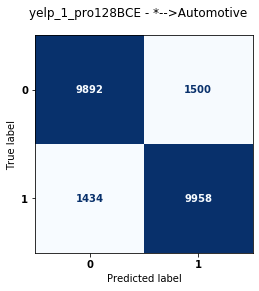

Work on Beauty & Spas ...


  0%|          | 0/4991 [00:00<?, ?it/s]

#ss (pos) 9982
#ss (neg) 9982


100%|██████████| 4991/4991 [00:09<00:00, 517.70it/s]


#nss 19964
#~ss 39928
review pairs: 39928


  0%|          | 0/1248 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1248/1248 [05:24<00:00,  4.16it/s]


Time for [prediction]: 0:05:24.469486
Confusion Matrix:
[[17584  2380]
 [ 2254 17710]]

CM: [17584  2380  2254 17710] 
[tn, fp, fn, tp]
  accuracy: 0.884
 precision: 0.884
    recall: 0.884
  f1-score: 0.884

Accuracy:  0.884 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     19964
           1       0.88      0.89      0.88     19964

    accuracy                           0.88     39928
   macro avg       0.88      0.88      0.88     39928
weighted avg       0.88      0.88      0.88     39928



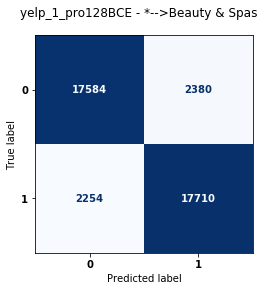

100%|██████████| 1/1 [00:00<00:00, 13.14it/s]

Work on Bicycles ...
#ss (pos) 2
#ss (neg) 2
#nss 4
#~ss 8
review pairs: 8
Start on [prediction] ...
Time for [prediction]: 0:00:00.078219
Confusion Matrix:
[[2 2]
 [1 3]]

CM: [2 2 1 3] 
[tn, fp, fn, tp]
  accuracy: 0.625
 precision: 0.633
    recall: 0.625
  f1-score: 0.619

Accuracy:  0.625 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Bicycles]:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



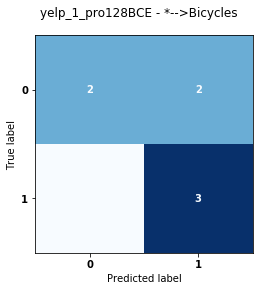

Work on Education ...


 11%|█         | 47/438 [00:00<00:00, 466.08it/s]

#ss (pos) 876
#ss (neg) 876


  0%|          | 0/110 [00:00<?, ?it/s]

#nss 1752
#~ss 3504
review pairs: 3504
Start on [prediction] ...


100%|██████████| 110/110 [00:31<00:00,  4.10it/s]


Time for [prediction]: 0:00:31.197639
Confusion Matrix:
[[1469  283]
 [ 284 1468]]

CM: [1469  283  284 1468] 
[tn, fp, fn, tp]
  accuracy: 0.838
 precision: 0.838
    recall: 0.838
  f1-score: 0.838

Accuracy:  0.838 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Education]:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1752
           1       0.84      0.84      0.84      1752

    accuracy                           0.84      3504
   macro avg       0.84      0.84      0.84      3504
weighted avg       0.84      0.84      0.84      3504



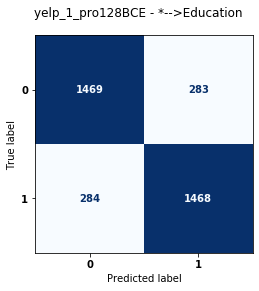

Work on Event Planning & Services ...


  0%|          | 0/3706 [00:00<?, ?it/s]

#ss (pos) 7412
#ss (neg) 7412


100%|██████████| 3706/3706 [00:07<00:00, 515.85it/s]


#nss 14824
#~ss 29648
review pairs: 29648


  0%|          | 0/927 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 927/927 [04:04<00:00,  4.51it/s]


Time for [prediction]: 0:04:04.516581
Confusion Matrix:
[[11957  2867]
 [ 2932 11892]]

CM: [11957  2867  2932 11892] 
[tn, fp, fn, tp]
  accuracy: 0.804
 precision: 0.804
    recall: 0.804
  f1-score: 0.804

Accuracy:  0.804 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     14824
           1       0.81      0.80      0.80     14824

    accuracy                           0.80     29648
   macro avg       0.80      0.80      0.80     29648
weighted avg       0.80      0.80      0.80     29648



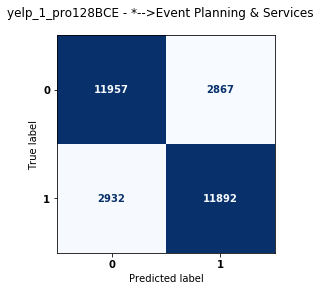

Work on Financial Services ...


 19%|█▊        | 55/296 [00:00<00:00, 544.19it/s]

#ss (pos) 592
#ss (neg) 592


  0%|          | 0/74 [00:00<?, ?it/s]

#nss 1184
#~ss 2368
review pairs: 2368
Start on [prediction] ...


100%|██████████| 74/74 [00:18<00:00,  3.86it/s]

Time for [prediction]: 0:00:18.641209
Confusion Matrix:
[[1039  145]
 [ 137 1047]]

CM: [1039  145  137 1047] 
[tn, fp, fn, tp]
  accuracy: 0.881
 precision: 0.881
    recall: 0.881
  f1-score: 0.881

Accuracy:  0.881 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Financial Services]:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1184
           1       0.88      0.88      0.88      1184

    accuracy                           0.88      2368
   macro avg       0.88      0.88      0.88      2368
weighted avg       0.88      0.88      0.88      2368



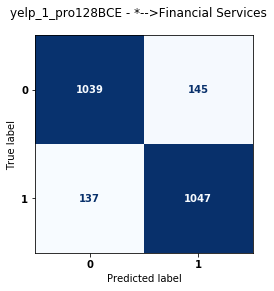

Work on Food ...


100%|██████████| 12779/12779 [00:25<00:00, 493.52it/s]


#ss (pos) 25558
#ss (neg) 25558


100%|██████████| 12779/12779 [00:25<00:00, 506.11it/s]


#nss 51116
#~ss 102232
review pairs: 102232


  0%|          | 0/3195 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 3195/3195 [13:18<00:00,  4.30it/s]


Time for [prediction]: 0:13:18.942238
Confusion Matrix:
[[40733 10383]
 [10399 40717]]

CM: [40733 10383 10399 40717] 
[tn, fp, fn, tp]
  accuracy: 0.797
 precision: 0.797
    recall: 0.797
  f1-score: 0.797

Accuracy:  0.797 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Food]:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     51116
           1       0.80      0.80      0.80     51116

    accuracy                           0.80    102232
   macro avg       0.80      0.80      0.80    102232
weighted avg       0.80      0.80      0.80    102232



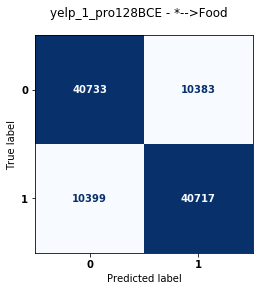

Work on Health & Medical ...


  1%|          | 36/3180 [00:00<00:08, 357.85it/s]

#ss (pos) 6360
#ss (neg) 6360


100%|██████████| 3180/3180 [00:05<00:00, 530.72it/s]


#nss 12720
#~ss 25440
review pairs: 25440


  0%|          | 0/795 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 795/795 [03:32<00:00,  3.95it/s]


Time for [prediction]: 0:03:32.118800
Confusion Matrix:
[[11237  1483]
 [ 1395 11325]]

CM: [11237  1483  1395 11325] 
[tn, fp, fn, tp]
  accuracy: 0.887
 precision: 0.887
    recall: 0.887
  f1-score: 0.887

Accuracy:  0.887 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12720
           1       0.88      0.89      0.89     12720

    accuracy                           0.89     25440
   macro avg       0.89      0.89      0.89     25440
weighted avg       0.89      0.89      0.89     25440



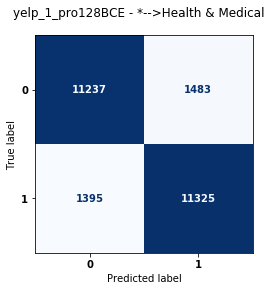

Work on Home Services ...


  1%|          | 34/3093 [00:00<00:09, 338.47it/s]

#ss (pos) 6186
#ss (neg) 6186


100%|██████████| 3093/3093 [00:06<00:00, 511.95it/s]


#nss 12372
#~ss 24744
review pairs: 24744


  0%|          | 0/774 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 774/774 [03:32<00:00,  3.64it/s]


Time for [prediction]: 0:03:32.545172
Confusion Matrix:
[[10917  1455]
 [ 1419 10953]]

CM: [10917  1455  1419 10953] 
[tn, fp, fn, tp]
  accuracy: 0.884
 precision: 0.884
    recall: 0.884
  f1-score: 0.884

Accuracy:  0.884 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Home Services]:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12372
           1       0.88      0.89      0.88     12372

    accuracy                           0.88     24744
   macro avg       0.88      0.88      0.88     24744
weighted avg       0.88      0.88      0.88     24744



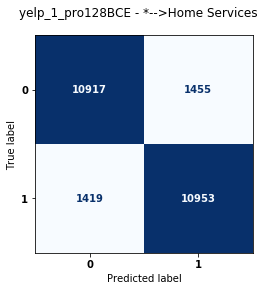

Work on Hotels & Travel ...


  0%|          | 8/2223 [00:00<00:27, 79.79it/s]

#ss (pos) 4446
#ss (neg) 4446


100%|██████████| 2223/2223 [00:04<00:00, 484.96it/s]


#nss 8892
#~ss 17784
review pairs: 17784


  0%|          | 0/556 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 556/556 [02:32<00:00,  3.79it/s]


Time for [prediction]: 0:02:32.257164
Confusion Matrix:
[[7143 1749]
 [1736 7156]]

CM: [7143 1749 1736 7156] 
[tn, fp, fn, tp]
  accuracy: 0.804
 precision: 0.804
    recall: 0.804
  f1-score: 0.804

Accuracy:  0.804 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      8892
           1       0.80      0.80      0.80      8892

    accuracy                           0.80     17784
   macro avg       0.80      0.80      0.80     17784
weighted avg       0.80      0.80      0.80     17784



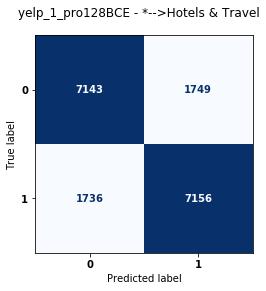

Work on Local Flavor ...


  9%|▊         | 44/508 [00:00<00:01, 439.32it/s]

#ss (pos) 1016
#ss (neg) 1016


100%|██████████| 508/508 [00:01<00:00, 498.77it/s]


#nss 2032
#~ss 4064
review pairs: 4064


  0%|          | 0/127 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 127/127 [00:33<00:00,  3.74it/s]

Time for [prediction]: 0:00:33.076205
Confusion Matrix:
[[1550  482]
 [ 436 1596]]

CM: [1550  482  436 1596] 
[tn, fp, fn, tp]
  accuracy: 0.774
 precision: 0.774
    recall: 0.774
  f1-score: 0.774

Accuracy:  0.774 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2032
           1       0.77      0.79      0.78      2032

    accuracy                           0.77      4064
   macro avg       0.77      0.77      0.77      4064
weighted avg       0.77      0.77      0.77      4064



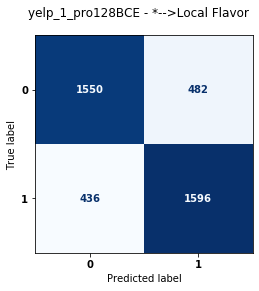

Work on Local Services ...


  2%|▏         | 42/2331 [00:00<00:05, 414.44it/s]

#ss (pos) 4662
#ss (neg) 4662


100%|██████████| 2331/2331 [00:04<00:00, 530.12it/s]


#nss 9324
#~ss 18648
review pairs: 18648


  0%|          | 0/583 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 583/583 [02:29<00:00,  4.10it/s]


Time for [prediction]: 0:02:29.825969
Confusion Matrix:
[[8146 1178]
 [1097 8227]]

CM: [8146 1178 1097 8227] 
[tn, fp, fn, tp]
  accuracy: 0.878
 precision: 0.878
    recall: 0.878
  f1-score: 0.878

Accuracy:  0.878 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Local Services]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      9324
           1       0.87      0.88      0.88      9324

    accuracy                           0.88     18648
   macro avg       0.88      0.88      0.88     18648
weighted avg       0.88      0.88      0.88     18648



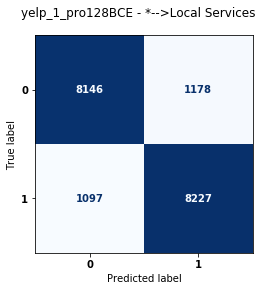

  0%|          | 0/35 [00:00<?, ?it/s]

Work on Mass Media ...
#ss (pos) 70
#ss (neg) 70


  0%|          | 0/9 [00:00<?, ?it/s]

#nss 140
#~ss 280
review pairs: 280
Start on [prediction] ...


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]

Time for [prediction]: 0:00:02.281582
Confusion Matrix:
[[122  18]
 [ 18 122]]

CM: [122  18  18 122] 
[tn, fp, fn, tp]
  accuracy: 0.871
 precision: 0.871
    recall: 0.871
  f1-score: 0.871

Accuracy:  0.871 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Mass Media]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       140
           1       0.87      0.87      0.87       140

    accuracy                           0.87       280
   macro avg       0.87      0.87      0.87       280
weighted avg       0.87      0.87      0.87       280



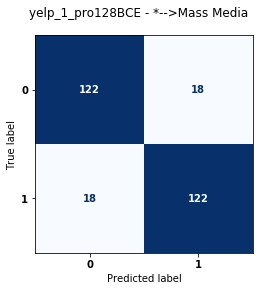

Work on Nightlife ...


100%|██████████| 8157/8157 [00:17<00:00, 474.50it/s]


#ss (pos) 16314
#ss (neg) 16314


100%|██████████| 8157/8157 [00:16<00:00, 484.06it/s]


#nss 32628
#~ss 65256
review pairs: 65256


  0%|          | 0/2040 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 2040/2040 [08:42<00:00,  3.90it/s]


Time for [prediction]: 0:08:42.606896
Confusion Matrix:
[[25788  6840]
 [ 7249 25379]]

CM: [25788  6840  7249 25379] 
[tn, fp, fn, tp]
  accuracy: 0.784
 precision: 0.784
    recall: 0.784
  f1-score: 0.784

Accuracy:  0.784 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Nightlife]:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79     32628
           1       0.79      0.78      0.78     32628

    accuracy                           0.78     65256
   macro avg       0.78      0.78      0.78     65256
weighted avg       0.78      0.78      0.78     65256



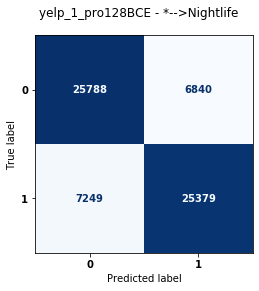

Work on Pets ...


  5%|▌         | 50/998 [00:00<00:01, 490.75it/s]

#ss (pos) 1996
#ss (neg) 1996


100%|██████████| 998/998 [00:01<00:00, 537.01it/s]


#nss 3992
#~ss 7984
review pairs: 7984


  0%|          | 0/250 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 250/250 [01:09<00:00,  4.20it/s]


Time for [prediction]: 0:01:09.692752
Confusion Matrix:
[[3406  586]
 [ 514 3478]]

CM: [3406  586  514 3478] 
[tn, fp, fn, tp]
  accuracy: 0.862
 precision: 0.862
    recall: 0.862
  f1-score: 0.862

Accuracy:  0.862 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Pets]:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3992
           1       0.86      0.87      0.86      3992

    accuracy                           0.86      7984
   macro avg       0.86      0.86      0.86      7984
weighted avg       0.86      0.86      0.86      7984



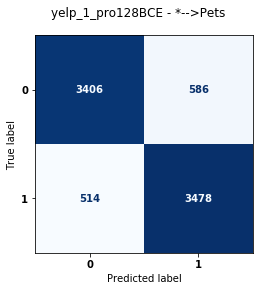

Work on Professional Services ...


  7%|▋         | 51/705 [00:00<00:01, 509.57it/s]

#ss (pos) 1410
#ss (neg) 1410


100%|██████████| 705/705 [00:01<00:00, 526.01it/s]


#nss 2820
#~ss 5640
review pairs: 5640


  0%|          | 0/177 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 177/177 [00:46<00:00,  3.83it/s]


Time for [prediction]: 0:00:46.161244
Confusion Matrix:
[[2478  342]
 [ 313 2507]]

CM: [2478  342  313 2507] 
[tn, fp, fn, tp]
  accuracy: 0.884
 precision: 0.884
    recall: 0.884
  f1-score: 0.884

Accuracy:  0.884 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Professional Services]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2820
           1       0.88      0.89      0.88      2820

    accuracy                           0.88      5640
   macro avg       0.88      0.88      0.88      5640
weighted avg       0.88      0.88      0.88      5640



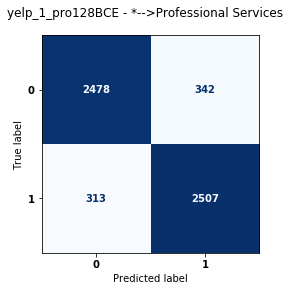

Work on Public Services & Government ...


 18%|█▊        | 53/290 [00:00<00:00, 527.33it/s]

#ss (pos) 580
#ss (neg) 580


  0%|          | 0/73 [00:00<?, ?it/s]

#nss 1160
#~ss 2320
review pairs: 2320
Start on [prediction] ...


100%|██████████| 73/73 [00:18<00:00,  4.38it/s]


Time for [prediction]: 0:00:18.885359
Confusion Matrix:
[[920 240]
 [240 920]]

CM: [920 240 240 920] 
[tn, fp, fn, tp]
  accuracy: 0.793
 precision: 0.793
    recall: 0.793
  f1-score: 0.793

Accuracy:  0.793 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1160
           1       0.79      0.79      0.79      1160

    accuracy                           0.79      2320
   macro avg       0.79      0.79      0.79      2320
weighted avg       0.79      0.79      0.79      2320



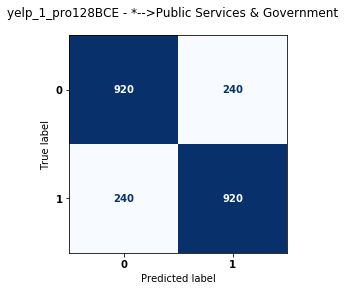

  0%|          | 0/43 [00:00<?, ?it/s]

Work on Religious Organizations ...


  0%|          | 0/43 [00:00<?, ?it/s]

#ss (pos) 86
#ss (neg) 86


  0%|          | 0/11 [00:00<?, ?it/s]

#nss 172
#~ss 344
review pairs: 344
Start on [prediction] ...


100%|██████████| 11/11 [00:02<00:00,  4.11it/s]

Time for [prediction]: 0:00:02.882581
Confusion Matrix:
[[130  42]
 [ 33 139]]

CM: [130  42  33 139] 
[tn, fp, fn, tp]
  accuracy: 0.782
 precision: 0.783
    recall: 0.782
  f1-score: 0.782

Accuracy:  0.782 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       172
           1       0.77      0.81      0.79       172

    accuracy                           0.78       344
   macro avg       0.78      0.78      0.78       344
weighted avg       0.78      0.78      0.78       344



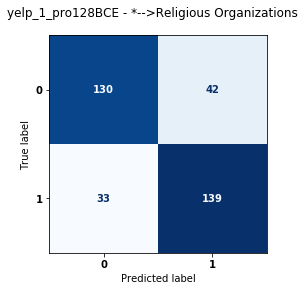

Work on Restaurants ...


100%|██████████| 33354/33354 [01:10<00:00, 471.79it/s]


#ss (pos) 66708
#ss (neg) 66708


100%|██████████| 33354/33354 [01:09<00:00, 478.34it/s]


#nss 133416
#~ss 266832
review pairs: 266832


  0%|          | 0/8339 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 8339/8339 [35:08<00:00,  4.50it/s]


Time for [prediction]: 0:35:08.783048
Confusion Matrix:
[[107014  26402]
 [ 27039 106377]]

CM: [107014  26402  27039 106377] 
[tn, fp, fn, tp]
  accuracy: 0.800
 precision: 0.800
    recall: 0.800
  f1-score: 0.800

Accuracy:  0.8 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Restaurants]:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    133416
           1       0.80      0.80      0.80    133416

    accuracy                           0.80    266832
   macro avg       0.80      0.80      0.80    266832
weighted avg       0.80      0.80      0.80    266832



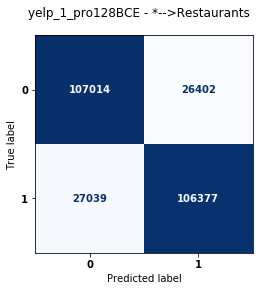

Work on Shopping ...


  0%|          | 0/6597 [00:00<?, ?it/s]

#ss (pos) 13194
#ss (neg) 13194


100%|██████████| 6597/6597 [00:12<00:00, 526.38it/s]


#nss 26388
#~ss 52776
review pairs: 52776


  0%|          | 0/1650 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1650/1650 [07:11<00:00,  3.83it/s]


Time for [prediction]: 0:07:11.090066
Confusion Matrix:
[[21658  4730]
 [ 4390 21998]]

CM: [21658  4730  4390 21998] 
[tn, fp, fn, tp]
  accuracy: 0.827
 precision: 0.827
    recall: 0.827
  f1-score: 0.827

Accuracy:  0.827 

Report for [BERTClassifier - yelp_1_pro128BCE - *-->Shopping]:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     26388
           1       0.82      0.83      0.83     26388

    accuracy                           0.83     52776
   macro avg       0.83      0.83      0.83     52776
weighted avg       0.83      0.83      0.83     52776



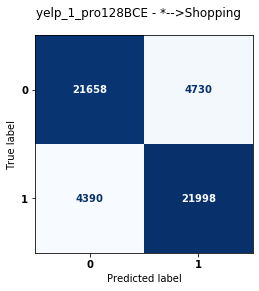

In [37]:
results_cross_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # with overlap
    df_other = load_cached_root_category_businesses_df(root_category_label, map_categories)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    # TODO: maybe reset randomness here, so previous calls to random don't influence it?
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_overlap[root_category_label] = res_one

In [ ]:
results_cross_no_overlap

In [38]:
results_cross_overlap

{'Active Life': (16312,
  16312,
  0.8021785808206973,
  0.8021701814615008,
  0.8021688067319881,
  0.8021701814615008,
  array([[6564, 1592],
         [1635, 6521]])),
 'Arts & Entertainment': (18232,
  18232,
  0.76564454349865,
  0.7656318560772268,
  0.7656290576356741,
  0.7656318560772268,
  array([[7011, 2105],
         [2168, 6948]])),
 'Automotive': (22784,
  22784,
  0.8712378819841751,
  0.8712254213483146,
  0.8712243407564115,
  0.8712254213483146,
  array([[9892, 1500],
         [1434, 9958]])),
 'Beauty & Spas': (39928,
  39928,
  0.8839563882078987,
  0.8839410939691444,
  0.8839399382061792,
  0.8839410939691444,
  array([[17584,  2380],
         [ 2254, 17710]])),
 'Bicycles': (8,
  8,
  0.6333333333333333,
  0.625,
  0.6190476190476191,
  0.625,
  array([[2, 2],
         [1, 3]])),
 'Education': (3504,
  3504,
  0.8381850416826437,
  0.8381849315068493,
  0.8381849183275961,
  0.8381849315068494,
  array([[1469,  283],
         [ 284, 1468]])),
 'Event Planning & Se

In [ ]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_no_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

yelp3 - arts - results_cross_no_overlap

```
Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 66.13%  66.11%  66.10%  66.11%  -- [4555, 2177, 2386, 4346]
Automotive                    : 69.38%  69.32%  69.30%  69.32%  -- [7544, 3772, 3171, 8145]
Beauty & Spas                 : 71.49%  71.39%  71.36%  71.39%  -- [13438, 6338, 4977, 14799]
Bicycles                      : 36.67%  37.50%  36.51%  37.50%  -- [2, 2, 3, 1]
Education                     : 67.60%  67.59%  67.58%  67.59%  -- [984, 500, 462, 1022]
Event Planning & Services     : 64.92%  64.92%  64.92%  64.92%  -- [8209, 4591, 4390, 8410]
Financial Services            : 71.96%  71.86%  71.84%  71.86%  -- [810, 370, 294, 886]
Food                          : 64.13%  64.13%  64.12%  64.13%  -- [31446, 18498, 17336, 32608]
Health & Medical              : 71.18%  70.96%  70.89%  70.96%  -- [8348, 4320, 3037, 9631]
Home Services                 : 71.00%  70.74%  70.64%  70.74%  -- [7993, 4287, 2900, 9380]
Hotels & Travel               : 66.15%  66.15%  66.15%  66.15%  -- [5319, 2733, 2719, 5333]
Local Flavor                  : 63.48%  63.48%  63.48%  63.48%  -- [933, 543, 535, 941]
Local Services                : 69.70%  69.54%  69.48%  69.54%  -- [5951, 3197, 2376, 6772]
Mass Media                    : 69.96%  69.85%  69.81%  69.85%  -- [100, 36, 46, 90]
Nightlife                     : 63.78%  63.76%  63.75%  63.76%  -- [18605, 9831, 10777, 17659]
Pets                          : 68.92%  68.91%  68.90%  68.91%  -- [2673, 1283, 1177, 2779]
Professional Services         : 71.54%  71.38%  71.33%  71.38%  -- [1844, 904, 669, 2079]
Public Services & Government  : 63.53%  63.51%  63.49%  63.51%  -- [685, 359, 403, 641]
Religious Organizations       : 64.04%  63.78%  63.62%  63.78%  -- [89, 67, 46, 110]
Restaurants                   : 64.42%  64.41%  64.41%  64.41%  -- [82341, 48231, 44705, 85867]
Shopping                      : 66.98%  66.98%  66.98%  66.98%  -- [16869, 8455, 8267, 17057]
```

In [39]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 80.22%  80.22%  80.22%  80.22%  -- [6564, 1592, 1635, 6521]
Arts & Entertainment          : 76.56%  76.56%  76.56%  76.56%  -- [7011, 2105, 2168, 6948]
Automotive                    : 87.12%  87.12%  87.12%  87.12%  -- [9892, 1500, 1434, 9958]
Beauty & Spas                 : 88.40%  88.39%  88.39%  88.39%  -- [17584, 2380, 2254, 17710]
Bicycles                      : 63.33%  62.50%  61.90%  62.50%  -- [2, 2, 1, 3]
Education                     : 83.82%  83.82%  83.82%  83.82%  -- [1469, 283, 284, 1468]
Event Planning & Services     : 80.44%  80.44%  80.44%  80.44%  -- [11957, 2867, 2932, 11892]
Financial Services            : 88.09%  88.09%  88.09%  88.09%  -- [1039, 145, 137, 1047]
Food                          : 79.67%  79.67%  79.67%  79.67%  -- [40733, 10383, 10399, 40717]
Health & Medical              : 88.69%  88.69%  88.69%  88.69%  -- [11237, 1483, 1395,

yelp1 - all - check sub-main-categories - results_cross_overlap

```
Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 80.22%  80.22%  80.22%  80.22%  -- [6564, 1592, 1635, 6521]
Arts & Entertainment          : 76.56%  76.56%  76.56%  76.56%  -- [7011, 2105, 2168, 6948]
Automotive                    : 87.12%  87.12%  87.12%  87.12%  -- [9892, 1500, 1434, 9958]
Beauty & Spas                 : 88.40%  88.39%  88.39%  88.39%  -- [17584, 2380, 2254, 17710]
Bicycles                      : 63.33%  62.50%  61.90%  62.50%  -- [2, 2, 1, 3]
Education                     : 83.82%  83.82%  83.82%  83.82%  -- [1469, 283, 284, 1468]
Event Planning & Services     : 80.44%  80.44%  80.44%  80.44%  -- [11957, 2867, 2932, 11892]
Financial Services            : 88.09%  88.09%  88.09%  88.09%  -- [1039, 145, 137, 1047]
Food                          : 79.67%  79.67%  79.67%  79.67%  -- [40733, 10383, 10399, 40717]
Health & Medical              : 88.69%  88.69%  88.69%  88.69%  -- [11237, 1483, 1395, 11325]
Home Services                 : 88.39%  88.39%  88.39%  88.39%  -- [10917, 1455, 1419, 10953]
Hotels & Travel               : 80.40%  80.40%  80.40%  80.40%  -- [7143, 1749, 1736, 7156]
Local Flavor                  : 77.43%  77.41%  77.41%  77.41%  -- [1550, 482, 436, 1596]
Local Services                : 87.80%  87.80%  87.80%  87.80%  -- [8146, 1178, 1097, 8227]
Mass Media                    : 87.14%  87.14%  87.14%  87.14%  -- [122, 18, 18, 122]
Nightlife                     : 78.41%  78.41%  78.41%  78.41%  -- [25788, 6840, 7249, 25379]
Pets                          : 86.23%  86.22%  86.22%  86.22%  -- [3406, 586, 514, 3478]
Professional Services         : 88.39%  88.39%  88.39%  88.39%  -- [2478, 342, 313, 2507]
Public Services & Government  : 79.31%  79.31%  79.31%  79.31%  -- [920, 240, 240, 920]
Religious Organizations       : 78.28%  78.20%  78.18%  78.20%  -- [130, 42, 33, 139]
Restaurants                   : 79.97%  79.97%  79.97%  79.97%  -- [107014, 26402, 27039, 106377]
Shopping                      : 82.72%  82.72%  82.72%  82.72%  -- [21658, 4730, 4390, 21998]
```

yelp3 - arts - results_cross_overlap

```
Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 65.54%  65.53%  65.53%  65.53%  -- [5403, 2753, 2869, 5287]
Automotive                    : 69.30%  69.26%  69.25%  69.26%  -- [7651, 3741, 3262, 8130]
Beauty & Spas                 : 71.36%  71.25%  71.22%  71.25%  -- [13534, 6430, 5048, 14916]
Bicycles                      : 50.00%  50.00%  46.67%  50.00%  -- [3, 1, 3, 1]
Education                     : 67.99%  67.98%  67.98%  67.98%  -- [1175, 577, 545, 1207]
Event Planning & Services     : 65.26%  65.26%  65.26%  65.26%  -- [9776, 5048, 5252, 9572]
Financial Services            : 72.46%  72.34%  72.30%  72.34%  -- [814, 370, 285, 899]
Food                          : 64.18%  64.17%  64.17%  64.17%  -- [32249, 18867, 17758, 33358]
Health & Medical              : 71.12%  70.96%  70.90%  70.96%  -- [8464, 4256, 3132, 9588]
Home Services                 : 70.69%  70.43%  70.33%  70.43%  -- [8014, 4358, 2959, 9413]
Hotels & Travel               : 64.97%  64.97%  64.97%  64.97%  -- [5750, 3142, 3087, 5805]
Local Flavor                  : 62.53%  62.52%  62.52%  62.52%  -- [1294, 738, 785, 1247]
Local Services                : 69.67%  69.51%  69.45%  69.51%  -- [6056, 3268, 2418, 6906]
Mass Media                    : 66.46%  66.43%  66.41%  66.43%  -- [96, 44, 50, 90]
Nightlife                     : 63.80%  63.78%  63.76%  63.78%  -- [21473, 11155, 12482, 20146]
Pets                          : 69.95%  69.90%  69.88%  69.90%  -- [2694, 1298, 1105, 2887]
Professional Services         : 69.65%  69.45%  69.37%  69.45%  -- [1815, 1005, 718, 2102]
Public Services & Government  : 64.51%  64.48%  64.47%  64.48%  -- [771, 389, 435, 725]
Religious Organizations       : 63.21%  63.08%  62.99%  63.08%  -- [100, 72, 55, 117]
Restaurants                   : 64.61%  64.60%  64.59%  64.60%  -- [84261, 49155, 45305, 88111]
Shopping                      : 66.42%  66.42%  66.42%  66.42%  -- [17444, 8944, 8780, 17608]
```

In [40]:
fn_results = fn_run_path / "results_cross_dicts.p"

with open(fn_results, "wb") as fp:
    pickle.dump((category_name, "overlap", results_cross_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump((category_name, "no overlap", results_cross_no_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)